<a href="https://colab.research.google.com/github/kamo1010/injury-big-data/blob/main/Random_forest_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 빅데이터 분석 코드


본 연구는 의료 진료를 위한 후송 데이터를 연구하려고자 합니다.
Random forest 알골즘을 바탕으로 환자의 생존과 사망을 예측하기 위해 후송 데이터를 활용해서 원인들의 중요성을 측정하기로 합니다.

## 데이터 후처리

csv 파일을 읽어서 데이터를 뽑기로 합니다.
Pandas framework을 써서 파일에 든 데이터를 Dataframe 현태로 불러옵니다.
우선 그러기 전에 필요한 코드 라이브러리를 불러옵니다.

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
from sklearn.model_selection import RandomizedSearchCV, train_test_split

Pandas를 써봅니다.

데이터를 불러와서 내용부터 확인해봅시다.

In [3]:
bank_data = pd.read_csv("sample_data/labels.csv", sep=";")
bank_data.head(5)

,연번,년도,월,일,날,주야간,기상조건,도시,지역,사무실,...,증상,환자유형,접수시간/이륙시간,환자 인수지역,도착시간/이륙시간,환자 후송지,후송지 도착 시간,복귀 이륙/복귀도착,출동~병원,후송결과
0,1,2021,7,27,목,주,go,대전,유성,문지로,...,두통,외상,1333/1344,A,1450/1503,대전병원,1537,1613/1720,133분,사망


칼럼 21개 중 후처리로 몇가지 새로운 데이터로 전환할 수 있습니다.

1. **``연번``**은 불필요한 ID 를 불러오며, 제거할 수 있겠습니다.
2. **``년도``**, **``월``**, **``일``** 행들을 **``날짜``** 데이터로 바꿀 수 있습니다. 추가로 월에거 **``계절``** 정보까지 수집할 수 있습니다.
3. **``주야간``** 데이터는 킵할 수 있겠습니다.
4. **``도시``**, **``지역``**, **``사무실``**, **``환자 인수지역``**, 그리고 **``환자 후송지``**는 지역과 후송 정보를 가지고 있으며 그대로 유지할 필요가 있다.
5. **``급``**, **``증상``**, **``환자유형``**은 환자의 부상 데이터를 묘사하므로 데이터를 유지해야 한다.
6. **``접수시간/이륙시간``**, **``도착시간/이륙시간	``**, **``복귀 이륙/복귀도착	``**과 **``후송지 도착 시간``**은 시간대를 알려주는 데이터들이며, 시간 데이터를 분리할 필요가 있습니다.
7. **``출동~병원``** 요소는 **``이륙시간``**과 **``후송지 도착 시간``**사이 흐른 기간을 묘사하며, 따로 계산이 가능합니다. 이 기간보다 **``접수기간``** 부터 **``후송지 도착시간``** 사이 기간이 환자 대기 기간에 더 가까우며 이 기간 계산을 **``대기기간``** 으로 택하기로 합니다. 또는 환자의 실제 후송 기간을 계산하여 **``후송 기간``** 을 계산하기로 합니다.
8. **``후송 결과``**를 예측하는 목적이므로, 이를 **``y``** label을 준다.

In [ ]:
bank_data['default'] = bank_data['default'].map({'no':0, 'yes':1, 'unknown':0})
bank_data['y'] = bank_data['y'].map({'no':0, 'yes':1})
bank_data.head(10)

,age,default,cons.price.idx,cons.conf.idx,y
0,56,0,93.994,-36.4,0
1,57,0,93.994,-36.4,0
2,37,0,93.994,-36.4,0
3,40,0,93.994,-36.4,0
4,56,0,93.994,-36.4,0
5,45,0,93.994,-36.4,0
6,59,0,93.994,-36.4,0
7,41,0,93.994,-36.4,0
8,24,0,93.994,-36.4,0
9,25,0,93.994,-36.4,0


In [ ]:
# Split the data into features (X) and target (y)
X = bank_data.drop('y', axis=1)
y = bank_data['y']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)

Accuracy:  0.8849235251274581
Precision:  0.4776357827476038
Recall: 0.21449067431850788


Forest population:  100


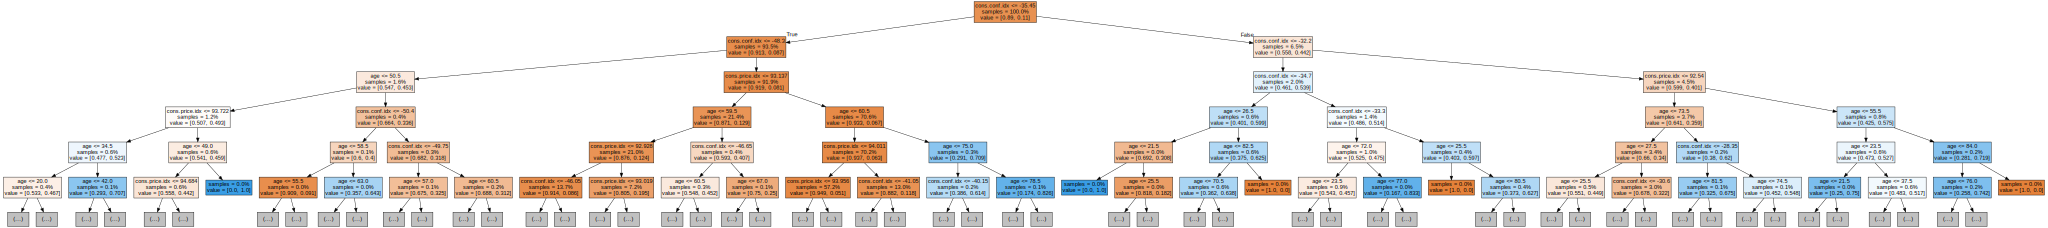

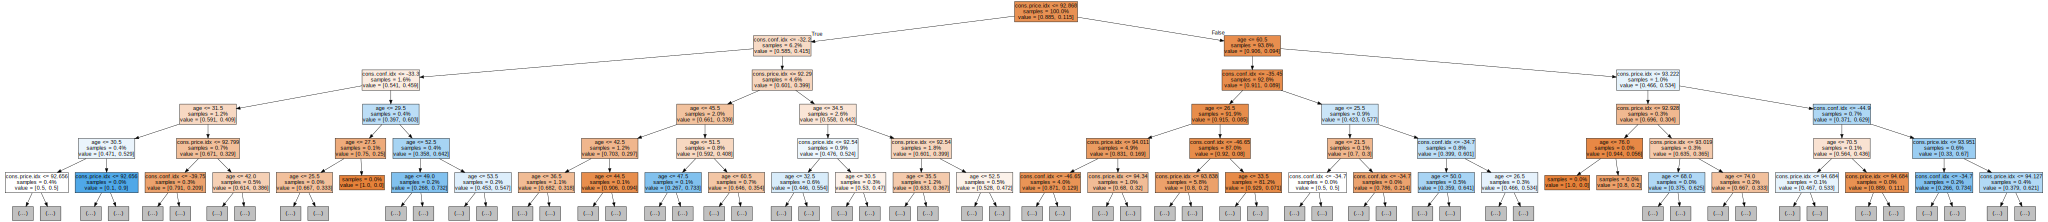

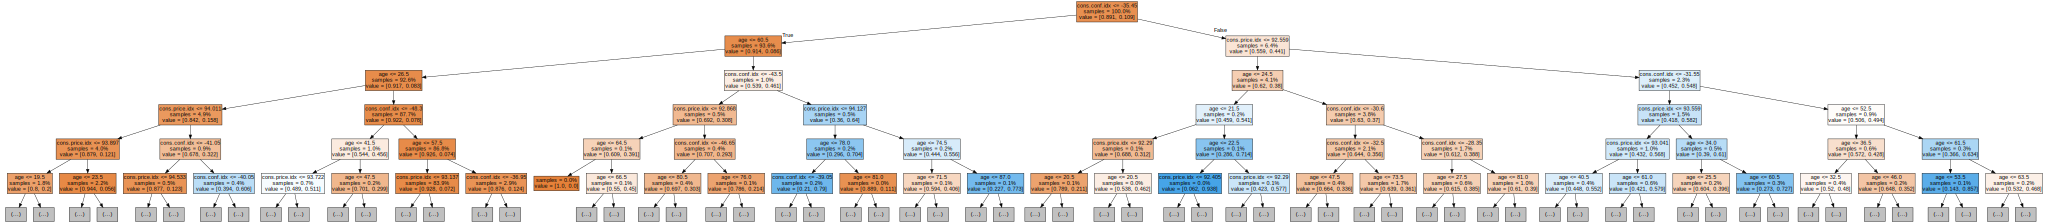

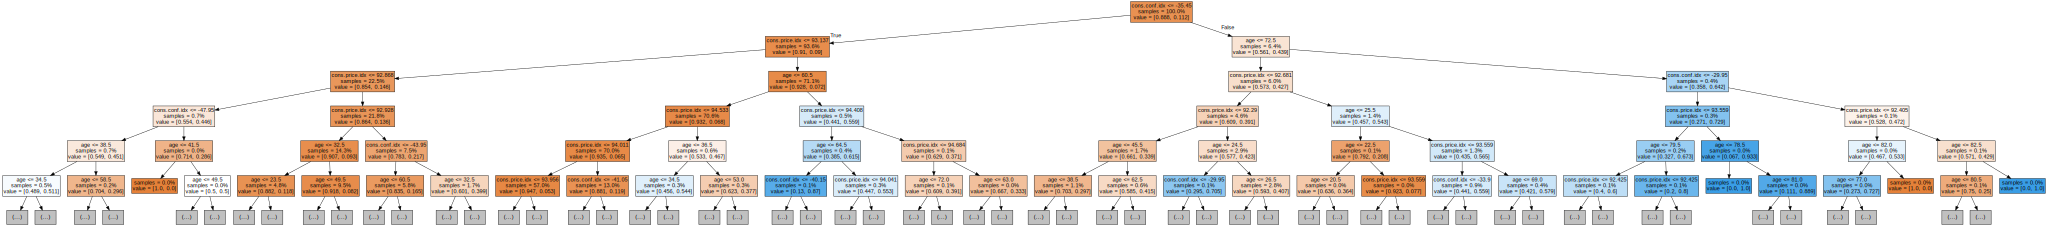

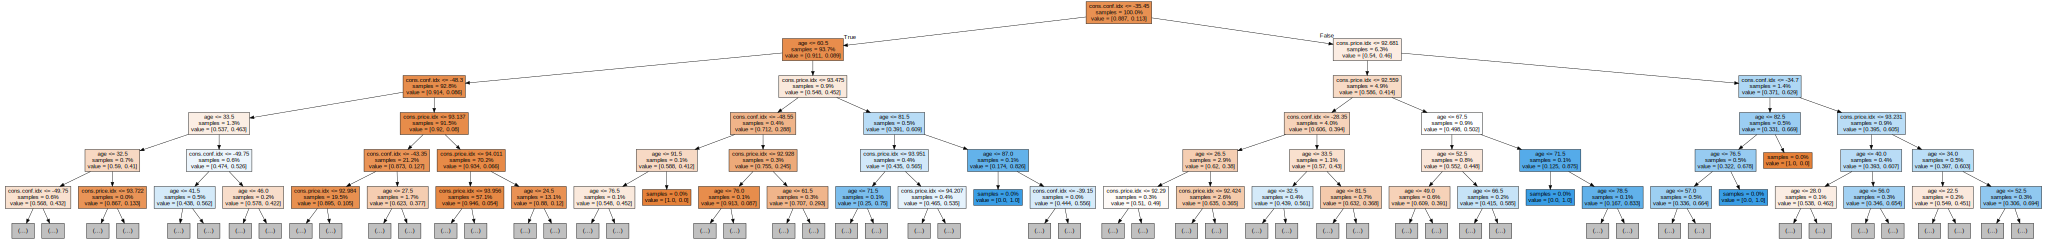

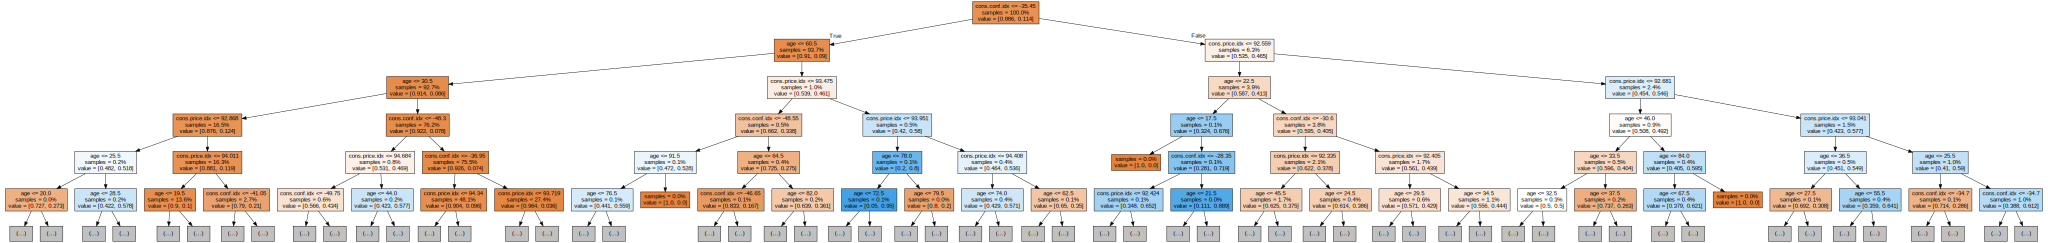

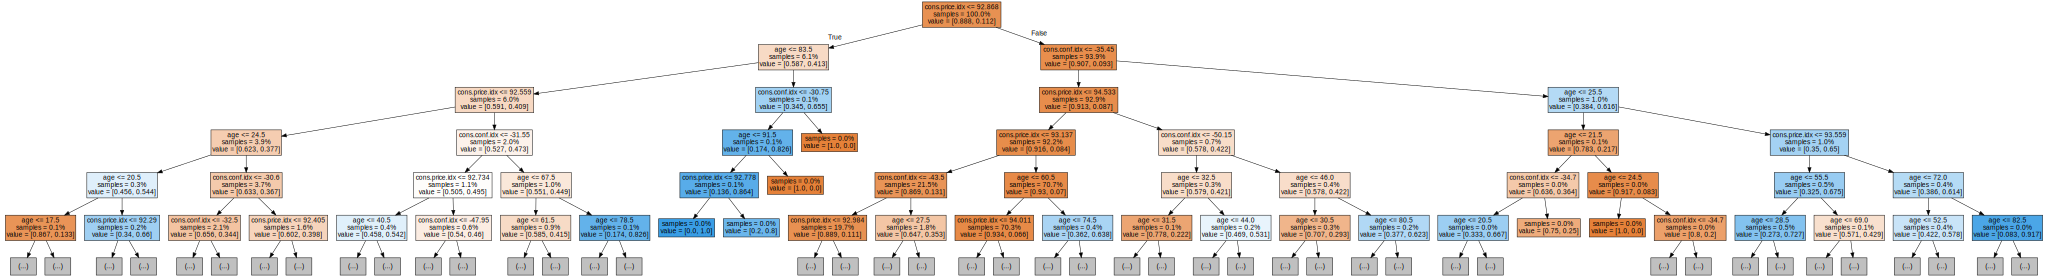

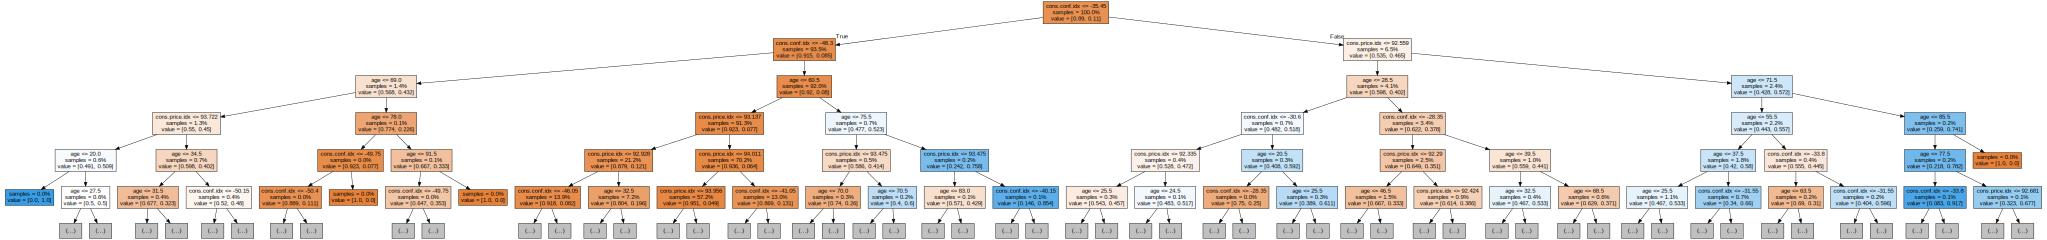

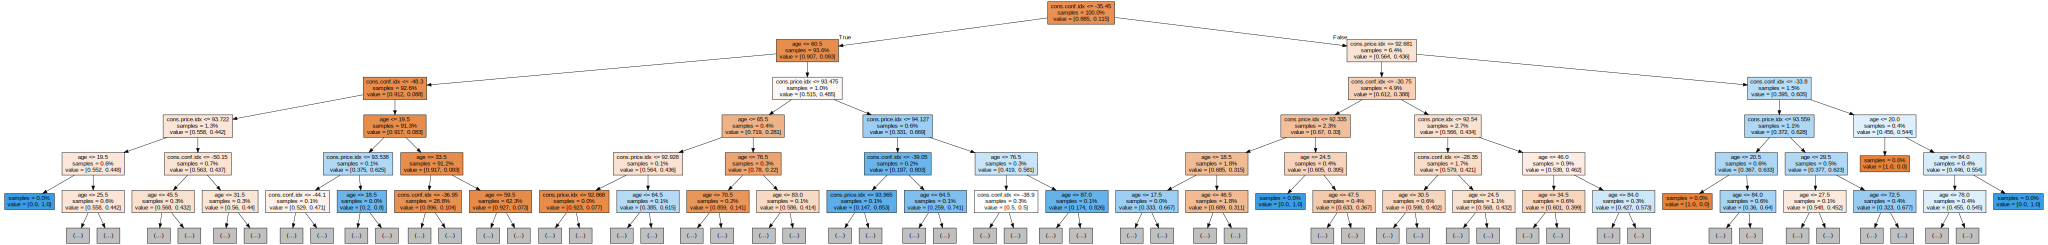

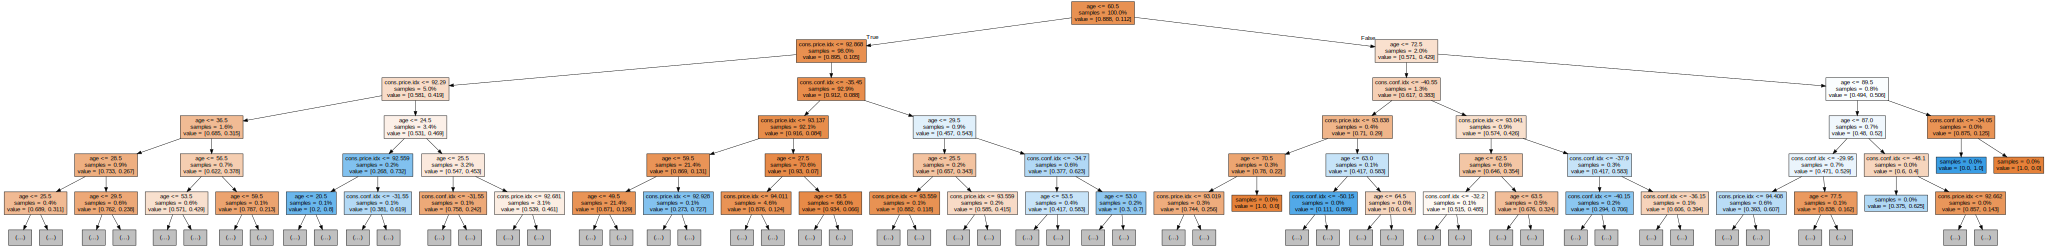

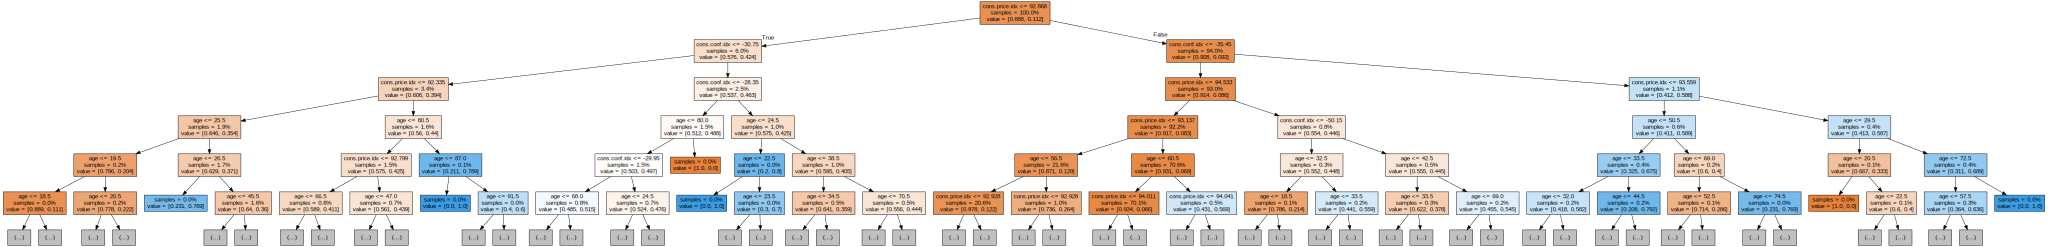

In [ ]:
print("Forest population: ", len(rf.estimators_))

# Export all the decision trees from the forest
for tree in rf.estimators_[:11]:
  dot_data = export_graphviz(tree, feature_names=X_train.columns, filled=True, max_depth=5, impurity=False, proportion=True)
  graph = graphviz.Source(dot_data)
  display(graph)

In [ ]:
n_estimators = randint(50, 500)
max_depth= randint(1, 20)


param_dist = {'n_estimators': n_estimators, 'max_depth': max_depth}

# Create a ranom forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, param_distributions = param_dist, n_iter=5, cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e7c4a4258a0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7e7c4a4243a0>})

In [ ]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best parameters
print('Best hyperparameters: ', rand_search.best_params_)

Best hyperparameters:  {'max_depth': 7, 'n_estimators': 95}


Accuracy:  0.8863801893663511
Precision:  0.4791666666666667
Recall: 0.0824964131994261
              precision    recall  f1-score   support

           0       0.89      0.99      0.94     10963
           1       0.48      0.08      0.14      1394

    accuracy                           0.89     12357
   macro avg       0.69      0.54      0.54     12357
weighted avg       0.85      0.89      0.85     12357



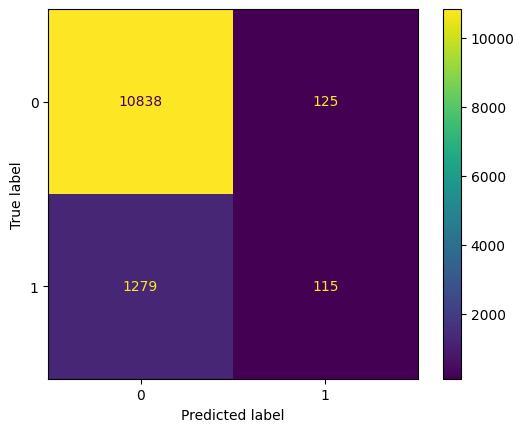

In [ ]:
# Generate predictions wit the best model
y_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)


# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

<Axes: >

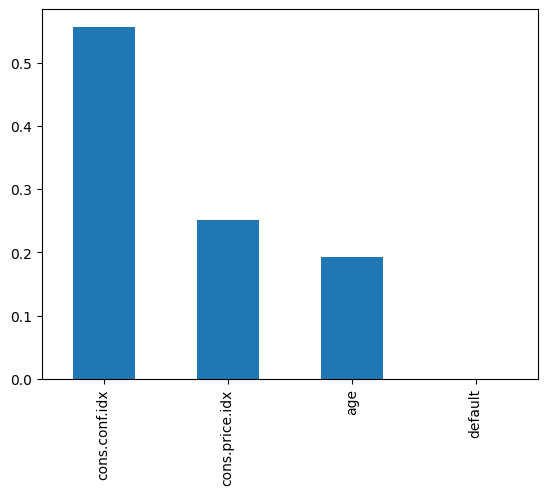

In [ ]:
# Create a series containing feature importances from the model and their names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar()

In [ ]:
from statistics import mean
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold
from imblearn.ensemble import BalancedRandomForestClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.parallel.delayed` should be used with `sklearn.utils.parallel.Parallel` to make it possible to propagate the scikit-learn configuration of the current thread to the joblib workers.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:86: FutureWarning: Function delayed is deprecated; The function `delayed` has been moved from `sklearn.utils.fixes` to `sklearn.utils.parallel`. This import path will be removed in 1.5.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py:114: UserWarning: `sklearn.utils.para

Accuracy:  0.8094197620781743
Precision:  0.31806134040136314
Recall: 0.6025824964131994
              precision    recall  f1-score   support

           0       0.94      0.84      0.89     10963
           1       0.32      0.60      0.42      1394

    accuracy                           0.81     12357
   macro avg       0.63      0.72      0.65     12357
weighted avg       0.87      0.81      0.83     12357



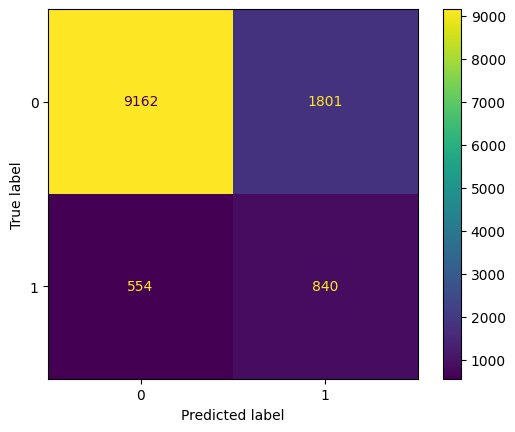

In [ ]:
# Build BRF model
BRFC = BalancedRandomForestClassifier(n_estimators=150, random_state=2)

# Create Strtified K-Fold cross validation
cv= RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('accuracy', 'precision', 'recall')

# Evaluate BRF model
'''scores = cross_validate(BRFC, X, y, scoring=scoring, cv=cv)
'''
BRFC.fit(X_train, y_train)

# BRFC prediction result
y_pred = BRFC.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)


# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))

Accuracy:  0.8404952658412236
Precision:  0.3693002257336343
Recall: 0.5876436781609196
              precision    recall  f1-score   support

           0       0.94      0.87      0.91     10965
           1       0.37      0.59      0.45      1392

    accuracy                           0.84     12357
   macro avg       0.66      0.73      0.68     12357
weighted avg       0.88      0.84      0.86     12357



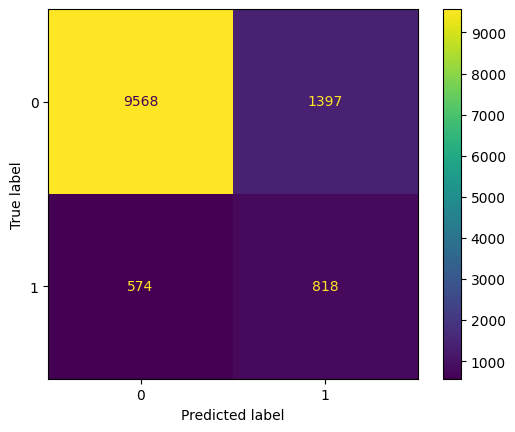

In [ ]:
from imblearn.over_sampling import SMOTE

# Use SMOTE to oversample the minority clss
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)

over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.3, stratify=over_y)

# Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=0)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scoring = ('accuracy', 'precision', 'recall')

# Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)


# Randomly split dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall:", recall)


# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()

# View the classification report for test data and predictions
print(classification_report(y_test, y_pred))
